In [1]:
include("../src/StatReg.jl")
using .StatReg

Define target function $\varphi(x) = \frac{\sin(x)}{x}$ with support $[-20,20]$:

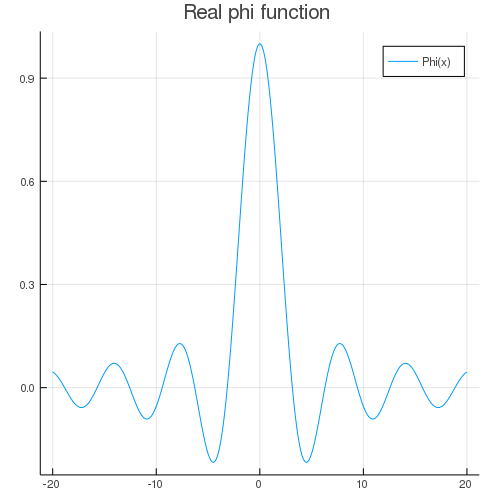

In [2]:
using Plots
plotly()
gr(size=(500,500), html_output_format=:png)

a = -20.
b = 20.

function phi(x::Real)
    if x != 0
        return sin(x)/x
    else
        return 1
    end
end

x = collect(range(a, stop=b, length=300))
myplot = plot(x, phi.(x), title="Real phi function",label=["Phi(x)"])

We will use diffraction kernel $K(x, y)$. $f(y)$ is an observed function, we need it to find the target function.

In [3]:
kernel(x::Real, y::Real) = getOpticsKernels("gaussian")(x, y)

using QuadGK
convolution = y -> quadgk(x -> kernel(x,y) * phi(x), a, b, rtol=10^-5, maxevals=10^7)[1]
y = collect(range(a, stop=b, length=30))
ftrue = convolution.(y)
print()

Generation of noise (measurement errors):

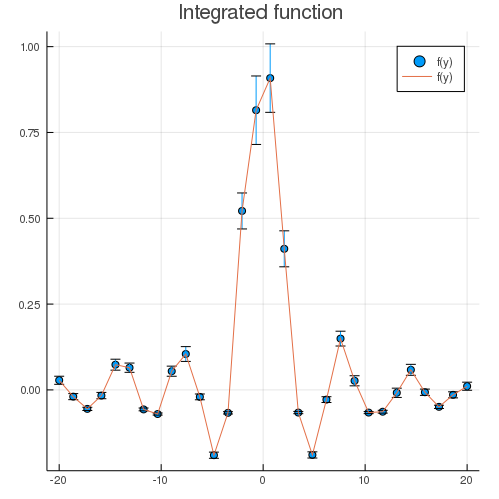

In [4]:
sig = ftrue*0.1 + [0.01 for i = 1:Base.length(ftrue)]

using Compat, Random, Distributions
noise = []
Random.seed!(1234)
for sigma in sig
    n = rand(Normal(0., abs(sigma)), 1)[1]
    push!(noise, n)
end

f = ftrue + noise
plot(y, f, title = "Integrated function", label = ["f(y)"], seriestype=:scatter, yerr=sig)
plot!(y, f, label = "f(y)")

We will use a Fourier Basis with 17 functions:

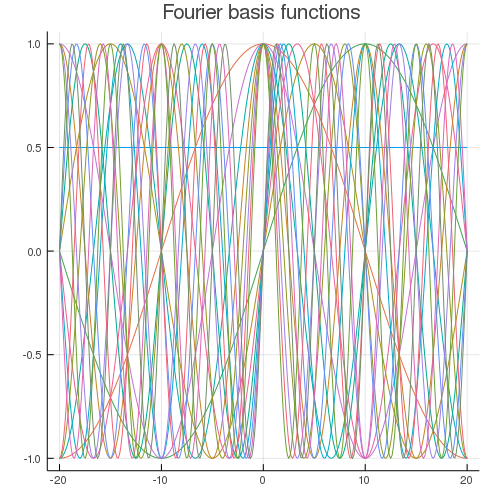

┌ Info: Fourier basis is created.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/basis.jl:118


In [5]:
basis = FourierBasis(a, b, 8)
p = plot()
for func in basis.basis_functions
    p = plot!(x, func.f.(x), title="Fourier basis functions", legend=false, show = true)
end
display(p)

┌ Info: Calculating omega matrix for Fourier basis derivatives of order 2...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/basis.jl:125
┌ Info: Omega caclulated successfully.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/basis.jl:141


┌ Info: GaussErrorMatrixUnfolder is created
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:59
┌ Info: GaussErrorUnfolder is created.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:163
┌ Info: Starting solve...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:196
┌ Info: Starting discretize kernel...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/basis.jl:45
┌ Info: Kernel was discretized successfully.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/basis.jl:56
┌ Info: Starting solve...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:89
┌ Info: Starting find_optimal_alpha...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/check.jl:122
┌ Info: Starting optimization...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/check.jl:147


Iter     Function value   Gradient norm 
     0     1.077109e+02     1.592287e+01
     1     5.370096e+01     1.421403e+01


┌ Warning: Linesearch failed, using alpha = 1.5004461230670062e-8 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/ta_nyan/.julia/packages/Optim/Agd3B/src/utilities/perform_linesearch.jl:47
┌ Warning: Minimization did not succeed, alpha = [9.99986], return alpha = 0.05.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/check.jl:158
┌ Info: Ending solve...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:107
┌ Info: Ending solve...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:204


┌ Info: PhiVec is created.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/vector.jl:64


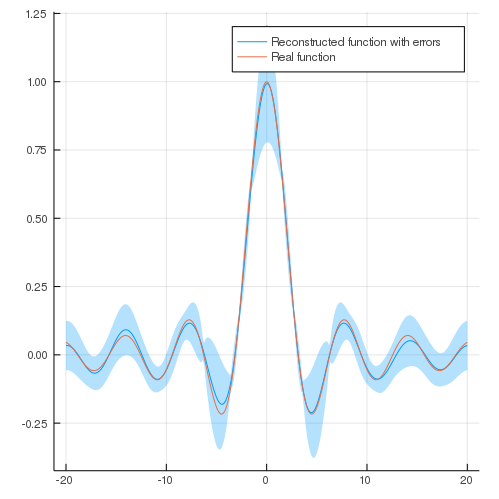

In [6]:
Omega = omega(basis, 2)
model = GaussErrorUnfolder(basis, [Omega], "EmpiricalBayes", lower=[1e-8], higher=[10.], initial=[0.3])
println()

result = solve(model, kernel, f, sig, y)
println()

phivec = PhiVec(result, basis)

phi_reconstructed = phivec.phi_function.(x)
phi_reconstructed_errors = phivec.error_function.(x)

plot(x, phi_reconstructed, ribbon=phi_reconstructed_errors, fillalpha=0.3, label="Reconstructed function with errors")
plot!(x, phi.(x), label="Real function")